In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append("../../")

from scipy.io import loadmat
from scipy.stats import wilcoxon
from statsmodels.stats.multitest import fdrcorrection

import seaborn as sns
from scipy.io import savemat
import pickle as pkl
import pingouin as pg
from scipy.stats import friedmanchisquare

In [2]:
# pip install seaborn==0.2.6

In [3]:
import ptitprince as ptit

In [4]:
##all the sessions data of EEG
data1=loadmat("../../../Database_PWelch_AvgTrials_MI_Baseline_RS1_19Subjects_EEG_Sess1.mat")
fvec=np.squeeze(data1["Freqs"])[3:30]

In [5]:
##modeled data
x_mi_all={}
x_base_all={}
x_rest_all={}

for num in range(1, 5):
    x_mi_all[num]=np.zeros((68, 10, 19))
    x_base_all[num]=np.zeros((68, 10, 19))
    x_rest_all[num]=np.zeros((68, 10, 19))
    
    for i in range(19):
        mi_fname = f'../bci_results_apd/bci_results/meg/sess{num}/mi_allsubs_f/mi_nostim_mse_db_fvec330_{i}.p'
        with open(mi_fname, 'rb') as f:
            x_mi_all[num][:,:,i]=np.array(pkl.load(f))

        base_fname = f'../bci_results_apd/bci_results/meg/sess{num}/baseline_allsubs_f/baseline_nostim_mse_db_fvec330_{i}.p'
        with open(base_fname, 'rb') as f:
            x_base_all[num][:,:,i] = np.array(pkl.load(f))
        
        rest_fname = f'../bci_results_apd/bci_results/meg/sess{num}/rs1_allsubs_f0/rs1_nostim_mse_db_fvec330_{i}.p'
        with open(rest_fname, 'rb') as f:
            x_rest_all[num][:,:,i]=np.array(pkl.load(f))


In [6]:
scores=np.squeeze(loadmat("../../../Performance_Sess4.mat")['Performance_Sess4'])
df=pd.read_excel('../../../spectrome-bci/spectrome/ListROIs_DK.xlsx')

In [7]:
#finding top and bottom performers (assuming 5-10%), say 10%
per_threshold=0.80
top_threshold=np.percentile(scores, 100*(1-per_threshold))
bot_threshold=np.percentile(scores, 100*per_threshold)
##give indices  
top_performers=np.where(scores>= top_threshold)[0]
bottom_performers=np.where(scores<= top_threshold)[0]

In [8]:
all_regions=[]
all_regions_idx=[]
for i,r in df.iterrows():
    all_regions_idx.append(i)
    all_regions.append(r['ROI'].strip("'"))

In [9]:
##session 4, significant regions for meg
gii_regions=['postcentral R', 'transversetemporal L']
# tau_e_regions=['bankssts L', 'cuneus L', 'entorhinal L', 'inferiorparietal L', 'inferiorparietal R', 'isthmuscingulate R', 'paracentral L', 'paracentral R', 
#  'pericalcarine L', 'postcentral L', 'postcentral R', 'posteriorcingulate L', 'posteriorcingulate R', 'precentral R', 'precuneus L', 'precuneus R', 
#  'supramarginal L', 'supramarginal R', 'transversetemporal L']
tau_e_regions=['paracentral L', 'postcentral L']

In [10]:
##top-performers
# tau_e_regions=['fusiform L', 'paracentral L', 'paracentral R', 'postcentral R', 'posteriorcingulate R', 'precuneus R', 'supramarginal R', 'temporalpole R', 'transversetemporal L']
# tau_e_regions=['paracentral L']

In [11]:
gii_idx=[]
tau_e_idx=[]
for idx, region in enumerate(all_regions):
    if region in gii_regions:
        gii_idx.append(idx)
for idx, region in enumerate(all_regions):
    if region in tau_e_regions:
        tau_e_idx.append(idx)


print(gii_idx, tau_e_idx)

[45, 66] [32, 44]


In [12]:
x_mi_all[4].shape, x_mi_all[1][45, 1, :]

((68, 10, 19),
 array([1.42758816e-01, 1.70322520e+00, 1.42995211e+00, 3.57027831e-01,
        1.37518173e+00, 8.06943373e-01, 1.89319634e+00, 1.91575523e-01,
        2.23968430e-01, 1.09683856e+00, 8.58429199e-01, 1.70533414e+00,
        2.06992230e-02, 1.51575756e+00, 1.19831868e-03, 2.07822212e-02,
        1.48563758e+00, 1.55551995e+00, 1.90000000e+00]))

In [13]:
for i in range(1,5):
    x_mi_all[i][45, 1, :], x_rest_all[i][45,1,:]

In [14]:
## tau_e
RED_TEXT = "\033[91m"
RESET_TEXT = "\033[0m"

mi_pvalues = []

for num in tau_e_idx:
    mi_data = []
    rest_data = []
    for sess in range(1, 5): 
        mi_values = x_mi_all[sess][num, 2, :]  
        rest_values = x_rest_all[sess][num, 2, :]  

        mi_data.append(mi_values)
        rest_data.append(rest_values)

    mi_data = np.array(mi_data)  #(4, 19)
    rest_data = np.array(rest_data) #(4, 19)

    friedman_mi = friedmanchisquare(mi_data[0], mi_data[1], mi_data[2], mi_data[3])
    mi_pvalues.append(friedman_mi.pvalue)
    friedman_rest = friedmanchisquare(rest_data[0], rest_data[1], rest_data[2], rest_data[3])

    #highlighting region where p-val < 0.05
    # region_name = all_regions[num]
    # if friedman_mi.pvalue < 0.05 or friedman_rest.pvalue < 0.05:
    #     region_name = f"{RED_TEXT}{region_name}{RESET_TEXT}"
    #     print(region_name)
    #     print(f"MI--> {friedman_mi.statistic:.4f}, p-value = {friedman_mi.pvalue:.4f}")
    #     print(f"Rest-->{friedman_rest.statistic:.4f}, p-value = {friedman_rest.pvalue:.4f}")

    # print(region_name)
    # print(f"MI--> {friedman_mi.statistic:.4f}, p-value = {friedman_mi.pvalue:.4f}")
    # print(f"Rest-->{friedman_rest.statistic:.4f}, p-value = {friedman_rest.pvalue:.4f}")

# fdr_corr_p=fdrcorrection(mi_pvalues)[1]
# # print(fdr_corr_p)
# for num in fdr_corr_p:
#     print(num)

# region_name = all_regions[num]
# if friedman_mi.pvalue < 0.05 or friedman_rest.pvalue < 0.05:
#     region_name = f"{RED_TEXT}{region_name}{RESET_TEXT}"
#     print(region_name)
#     print(f"MI--> {friedman_mi.statistic:.4f}, p-value = {friedman_mi.pvalue:.4f}")
#     print(f"Rest-->{friedman_rest.statistic:.4f}, p-value = {friedman_rest.pvalue:.4f}")

In [15]:
mi_pvalues

[0.04524437704665322, 0.48114905564805954]

In [16]:
# # Bonferroni correction
adjusted_p_values = [min(1, p * len(mi_pvalues)) for p in mi_pvalues]
print("Bonferroni-adjusted p-values:", adjusted_p_values)

# fdr_corr= fdrcorrection(mi_pvalues)[1]
# fdr_corr

Bonferroni-adjusted p-values: [0.09048875409330644, 0.9622981112961191]


In [17]:
##inedx of left paracentral region
for idx, region in enumerate(all_regions):
    print(idx, region)

0 bankssts L
1 bankssts R
2 caudalanteriorcingulate L
3 caudalanteriorcingulate R
4 caudalmiddlefrontal L
5 caudalmiddlefrontal R
6 cuneus L
7 cuneus R
8 entorhinal L
9 entorhinal R
10 frontalpole L
11 frontalpole R
12 fusiform L
13 fusiform R
14 inferiorparietal L
15 inferiorparietal R
16 inferiortemporal L
17 inferiortemporal R
18 insula L
19 insula R
20 isthmuscingulate L
21 isthmuscingulate R
22 lateraloccipital L
23 lateraloccipital R
24 lateralorbitofrontal L
25 lateralorbitofrontal R
26 lingual L
27 lingual R
28 medialorbitofrontal L
29 medialorbitofrontal R
30 middletemporal L
31 middletemporal R
32 paracentral L
33 paracentral R
34 parahippocampal L
35 parahippocampal R
36 parsopercularis L
37 parsopercularis R
38 parsorbitalis L
39 parsorbitalis R
40 parstriangularis L
41 parstriangularis R
42 pericalcarine L
43 pericalcarine R
44 postcentral L
45 postcentral R
46 posteriorcingulate L
47 posteriorcingulate R
48 precentral L
49 precentral R
50 precuneus L
51 precuneus R
52 ros

### top-perfomers

In [18]:
from scipy.stats import friedmanchisquare
from statsmodels.stats.multitest import multipletests
import numpy as np

RED_TEXT = "\033[91m"
RESET_TEXT = "\033[0m"

mi_pvalues = []

for num in tau_e_idx:
    mi_data = []
    rest_data = []
    for sess in range(1, 5): 
        mi_values = x_mi_all[sess][num, 2, :]  
        rest_values = x_rest_all[sess][num, 2, :]  

        mi_data.append(mi_values)
        rest_data.append(rest_values)

    mi_data = np.array(mi_data)  #(4, 19)
    rest_data = np.array(rest_data) #(4, 19)

    friedman_mi = friedmanchisquare(mi_data[0], mi_data[1], mi_data[2], mi_data[3])
    friedman_rest = friedmanchisquare(rest_data[0], rest_data[1], rest_data[2], rest_data[3])

    mi_pvalues.append(friedman_mi.pvalue)

# Apply FDR correction only to MI p-values
_, fdr_mi_pvalues, _, _ = multipletests(mi_pvalues, method='fdr_bh')

# Display results
for idx, num in enumerate(tau_e_idx):
    region_name = all_regions[num]

    if fdr_mi_pvalues[idx] < 0.05:  # Highlight if FDR-corrected MI p-value is significant
        region_name = f"{RED_TEXT}{region_name}{RESET_TEXT}"
    
    print(region_name)
    print(f"MI--> Corrected p-value = {fdr_mi_pvalues[idx]:.4f}")
    print(f"Rest--> Uncorrected p-value = {friedmanchisquare(x_rest_all[1][num, 2, :], x_rest_all[2][num, 2, :], x_rest_all[3][num, 2, :], x_rest_all[4][num, 2, :]).pvalue:.4f}")


paracentral L
MI--> Corrected p-value = 0.0905
Rest--> Uncorrected p-value = 0.5626
postcentral L
MI--> Corrected p-value = 0.4811
Rest--> Uncorrected p-value = 0.3365


In [19]:
##gii
RED_TEXT = "\033[91m"
RESET_TEXT = "\033[0m"

for num in gii_idx:
    mi_data = []
    rest_data = []
    for sess in range(1, 5): 
        mi_values = x_mi_all[sess][num, 1, :]  
        rest_values = x_rest_all[sess][num, 1, :]  

        mi_data.append(mi_values)
        rest_data.append(rest_values)

    mi_data = np.array(mi_data)  #(4, 19)
    rest_data = np.array(rest_data) #(4, 19)

    friedman_mi = friedmanchisquare(mi_data[0], mi_data[1], mi_data[2], mi_data[3])
    friedman_rest = friedmanchisquare(rest_data[0], rest_data[1], rest_data[2], rest_data[3])

    #highlighting region where p-val < 0.05
    region_name = all_regions[num]
    if friedman_mi.pvalue < 0.05 or friedman_rest.pvalue < 0.05:
        region_name = f"{RED_TEXT}{region_name}{RESET_TEXT}"
        print(region_name)
        print(f"MI--> {friedman_mi.statistic:.4f}, p-value = {friedman_mi.pvalue:.4f}")
        print(f"Rest-->{friedman_rest.statistic:.4f}, p-value = {friedman_rest.pvalue:.4f}")

    # print(region_name)
    # print(f"MI--> {friedman_mi.statistic:.4f}, p-value = {friedman_mi.pvalue:.4f}")
    # print(f"Rest-->{friedman_rest.statistic:.4f}, p-value = {friedman_rest.pvalue:.4f}")


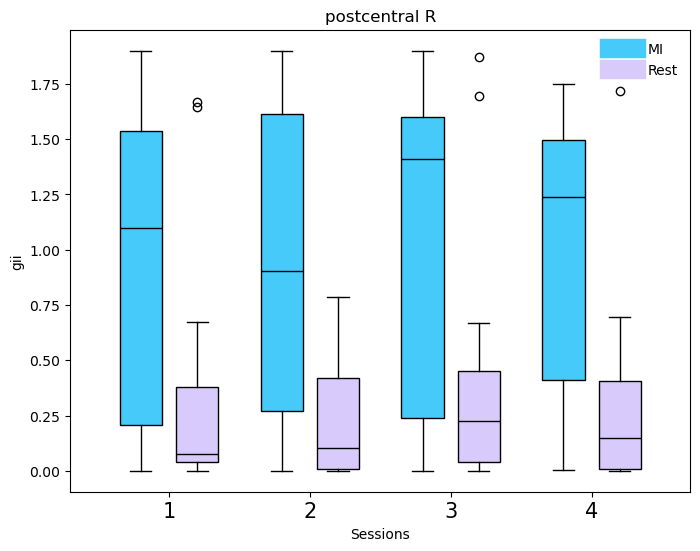

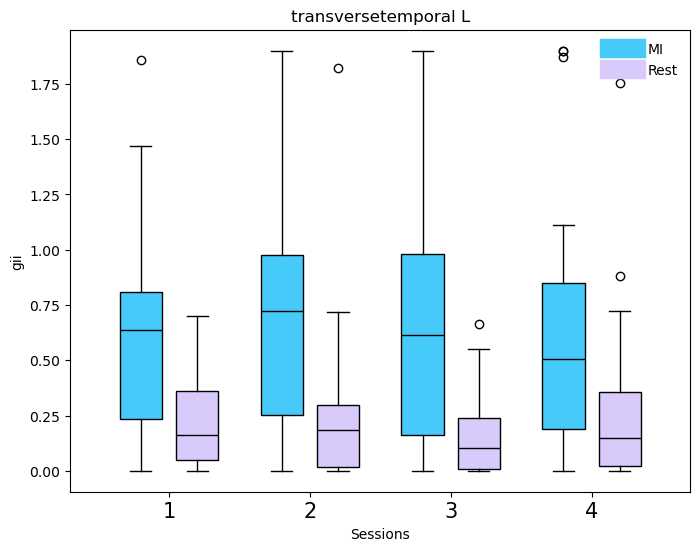

In [20]:
##for gii
for idx_region in gii_idx:
    sessions = range(1, 5)
    mi_values = [x_mi_all[i][idx_region, 1, :] for i in sessions]
    rest_values = [x_rest_all[i][idx_region, 1, :] for i in sessions]

    fig, ax = plt.subplots(figsize=(8, 6))
    colors = ['#46CAFA', '#D8CAFA']
    positions = []
    data = []
    box_colors = []

    for i, session in enumerate(sessions):
        positions.append(i-0.2) 
        data.append(mi_values[i])   
        box_colors.append(colors[0])
        
        positions.append(i+0.2) 
        data.append(rest_values[i])
        box_colors.append(colors[1])


    box = ax.boxplot(
        data, positions=positions, patch_artist=True, widths=0.3, medianprops={'color': 'black', 'linewidth': 1}  
    )


    for patch, color in zip(box['boxes'], box_colors):
        patch.set_facecolor(color)

    ax.set_title(f"{all_regions[idx_region]}")
    ax.set_xlabel("Sessions")
    ax.set_ylabel("gii")
    ax.set_xticks(range(len(sessions)))
    ax.set_xticklabels([str(s) for s in sessions], fontsize=15)
    ax.grid(False)

    legend_patches = [
        plt.Line2D([0], [0], color=colors[0], lw=14, label="MI"),
        plt.Line2D([0], [0], color=colors[1], lw=14, label="Rest")
    ]
    ax.legend(handles=legend_patches, frameon=False)

    plt.show()


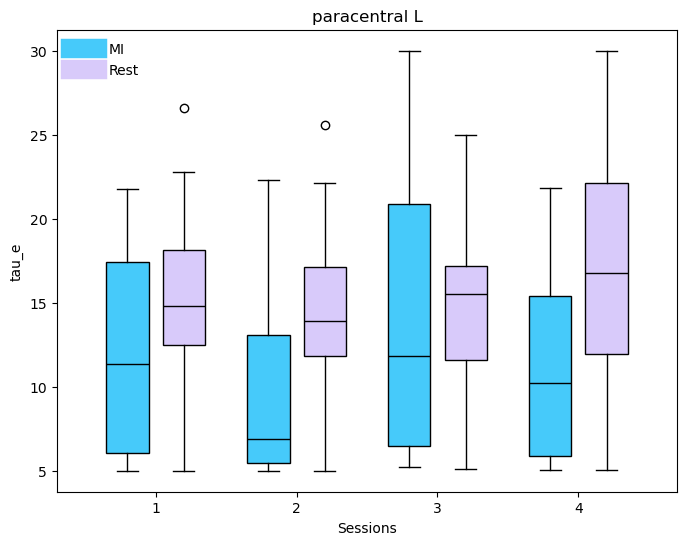

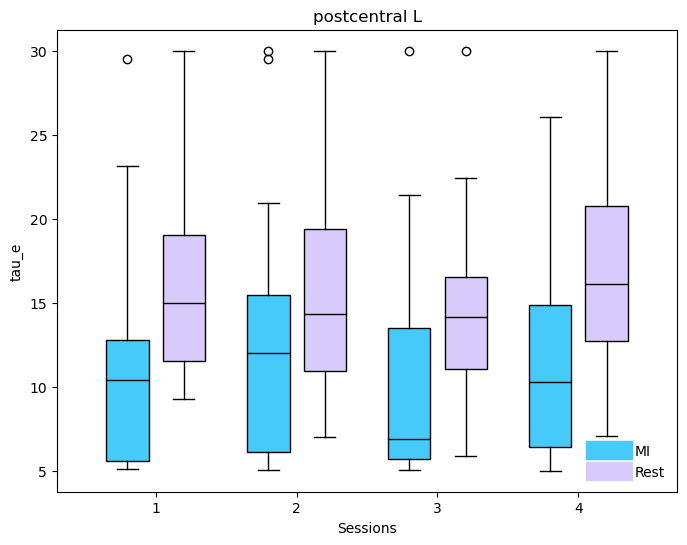

In [21]:
##for tau_e
for idx_region in tau_e_idx:
    sessions = range(1, 5)
    mi_values = [x_mi_all[i][idx_region, 2, :] for i in sessions]
    rest_values = [x_rest_all[i][idx_region, 2, :] for i in sessions]

    fig, ax = plt.subplots(figsize=(8, 6))
    colors = ['#46CAFA', '#D8CAFA']
    positions = []
    data = []
    box_colors = []

    for i, session in enumerate(sessions):
        positions.append(i-0.2) 
        data.append(mi_values[i])   
        box_colors.append(colors[0])
        
        positions.append(i+0.2) 
        data.append(rest_values[i])
        box_colors.append(colors[1])


    box = ax.boxplot(
        data, positions=positions, patch_artist=True, widths=0.3, medianprops={'color': 'black', 'linewidth': 1}  
    )


    for patch, color in zip(box['boxes'], box_colors):
        patch.set_facecolor(color)

    ax.set_title(f"{all_regions[idx_region]}")
    ax.set_xlabel("Sessions")
    ax.set_ylabel("tau_e")
    ax.set_xticks(range(len(sessions)))
    ax.set_xticklabels([str(s) for s in sessions])
    ax.grid(False)

    legend_patches = [
        plt.Line2D([0], [0], color=colors[0], lw=14, label="MI"),
        plt.Line2D([0], [0], color=colors[1], lw=14, label="Rest")
    ]
    ax.legend(handles=legend_patches, frameon=False)

    plt.show()


In [22]:
for idx, region in enumerate(all_regions):
    print(idx, all_regions[idx])

0 bankssts L
1 bankssts R
2 caudalanteriorcingulate L
3 caudalanteriorcingulate R
4 caudalmiddlefrontal L
5 caudalmiddlefrontal R
6 cuneus L
7 cuneus R
8 entorhinal L
9 entorhinal R
10 frontalpole L
11 frontalpole R
12 fusiform L
13 fusiform R
14 inferiorparietal L
15 inferiorparietal R
16 inferiortemporal L
17 inferiortemporal R
18 insula L
19 insula R
20 isthmuscingulate L
21 isthmuscingulate R
22 lateraloccipital L
23 lateraloccipital R
24 lateralorbitofrontal L
25 lateralorbitofrontal R
26 lingual L
27 lingual R
28 medialorbitofrontal L
29 medialorbitofrontal R
30 middletemporal L
31 middletemporal R
32 paracentral L
33 paracentral R
34 parahippocampal L
35 parahippocampal R
36 parsopercularis L
37 parsopercularis R
38 parsorbitalis L
39 parsorbitalis R
40 parstriangularis L
41 parstriangularis R
42 pericalcarine L
43 pericalcarine R
44 postcentral L
45 postcentral R
46 posteriorcingulate L
47 posteriorcingulate R
48 precentral L
49 precentral R
50 precuneus L
51 precuneus R
52 ros

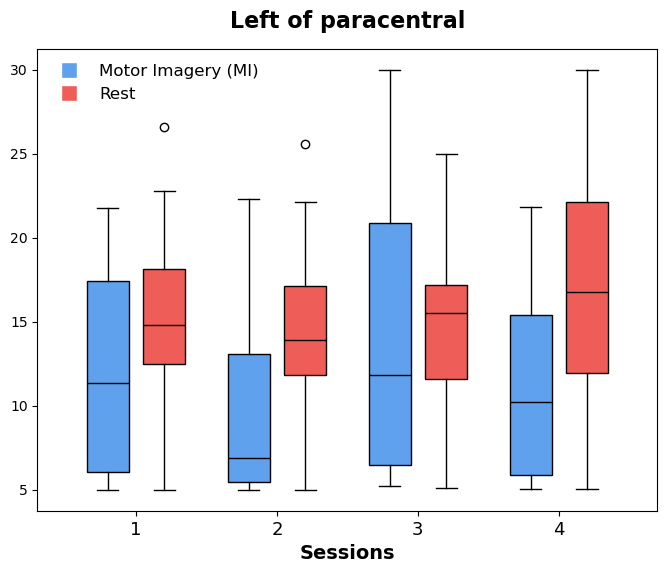

In [23]:
##IMPORTANT REGION
##for tau_e

sessions = range(1, 5)
mi_values = [x_mi_all[i][32, 2, :] for i in sessions]
rest_values = [x_rest_all[i][32, 2, :] for i in sessions]

fig, ax = plt.subplots(figsize=(8, 6))
colors = ['#5FA1ED', '#EF5D58']
positions = []
data = []
box_colors = []

for i, session in enumerate(sessions):
    positions.append(i-0.2) 
    data.append(mi_values[i])   
    box_colors.append(colors[0])
    
    positions.append(i+0.2) 
    data.append(rest_values[i])
    box_colors.append(colors[1])


box = ax.boxplot(
    data, positions=positions, patch_artist=True, widths=0.3, medianprops={'color': 'black', 'linewidth': 1}  
)


for patch, color in zip(box['boxes'], box_colors):
    patch.set_facecolor(color)

ax.set_title(f"Left of {all_regions[32][:-2]}", fontsize=16, fontweight="bold", pad=15)
ax.set_xlabel("Sessions", fontsize=14, fontweight="bold")
# ax.set_ylabel("tau_e")
ax.set_xticks(range(len(sessions)))
ax.set_xticklabels([str(s) for s in sessions],fontsize=13)
ax.grid(False)

legend_patches = [
    plt.Line2D([0], [0], marker='s', color='w', markersize=12, markerfacecolor=colors[0], label="Motor Imagery (MI)"),
    plt.Line2D([0], [0], marker='s', color='w', markersize=12, markerfacecolor=colors[1], label="Rest")
]
ax.legend(handles=legend_patches, frameon=False, loc="upper left", fontsize=12)

plt.show()


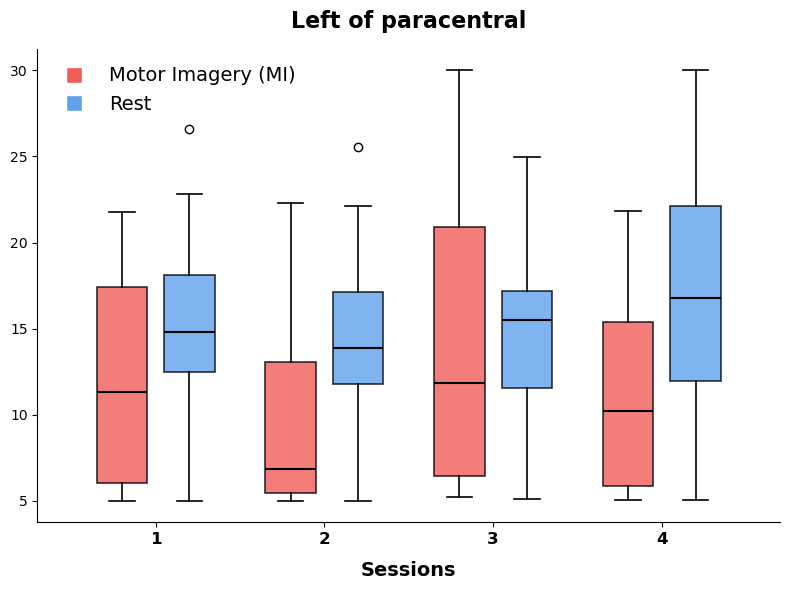

In [24]:
sessions = range(1, 5)
mi_values = [x_mi_all[i][32, 2, :] for i in sessions]
rest_values = [x_rest_all[i][32, 2, :] for i in sessions]

fig, ax = plt.subplots(figsize=(8, 6))

colors = ['#EF5D58','#5FA1ED'] 
positions = []
data = []
box_colors = []

for i, session in enumerate(sessions):
    positions.append(i - 0.2)  
    data.append(mi_values[i])
    box_colors.append(colors[0])

    positions.append(i + 0.2)  
    data.append(rest_values[i])
    box_colors.append(colors[1])

box = ax.boxplot(
    data, positions=positions, patch_artist=True, widths=0.3,
    medianprops={'color': 'black', 'linewidth': 1.5},
    whiskerprops={'linewidth': 1.2},
    capprops={'linewidth': 1.2},
    boxprops={'linewidth': 1.2}
)


for patch, color in zip(box['boxes'], box_colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.8)  

ax.set_title(f"Left of {all_regions[32][:-2]}", fontsize=16, fontweight="bold", pad=15)
ax.set_xlabel("Sessions", fontsize=14, fontweight="bold", labelpad=10)
# ax.set_ylabel("Metric Value", fontsize=14, fontweight="bold", labelpad=10)


ax.set_xticks(range(len(sessions)))
ax.set_xticklabels([str(s) for s in sessions], fontsize=12, fontweight="bold")

ax.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

legend_patches = [
    plt.Line2D([0], [0], marker='s', color='w', markersize=12, markerfacecolor=colors[0], label="Motor Imagery (MI)"),
    plt.Line2D([0], [0], marker='s', color='w', markersize=12, markerfacecolor=colors[1], label="Rest")
]
ax.legend(handles=legend_patches, frameon=False, loc="upper left", fontsize=14)
plt.tight_layout()
plt.show()


In [25]:
mi_values = [x_mi_all[i][32, 2, :] for i in sessions]
rest_values = [x_rest_all[i][32, 2, :] for i in sessions]

In [26]:
mi_values[0]

array([12.66315801, 10.0444083 , 16.20496109,  7.22804149, 12.47714879,
        6.39425041,  5.        , 21.49492218, 18.72939303,  6.43108511,
        5.34880418, 11.3273167 , 21.13362904,  5.71139973, 18.68768692,
       21.77326775, 15.91796722,  5.02241032,  5.27496494])

In [27]:
mi_values[3].shape

(19,)

## Raincloud plot

In [28]:
import ptitprince as pt

In [29]:
data_dict = {'Condition': [], 'taue': []}

# for i, session in enumerate(sessions):
    # data_dict['Session'] += [session] * len(mi_values[i]) + [session] * len(rest_values[i])
data_dict['Condition'] += ['MI'] * len(mi_values[0]) + ['Rest'] * len(rest_values[0])
data_dict['taue'] += list(mi_values[0]) + list(rest_values[0])
##session-1
df1 = pd.DataFrame(data_dict)


In [30]:
data_dict = {'Condition': [], 'taue': []}

# for i, session in enumerate(sessions):
    # data_dict['Session'] += [session] * len(mi_values[i]) + [session] * len(rest_values[i])
data_dict['Condition'] += ['MI'] * len(mi_values[1]) + ['Rest'] * len(rest_values[1])
data_dict['taue'] += list(mi_values[1]) + list(rest_values[1])
##session-2
df2 = pd.DataFrame(data_dict)


In [31]:
data_dict = {'Condition': [], 'taue': []}

# for i, session in enumerate(sessions):
    # data_dict['Session'] += [session] * len(mi_values[i]) + [session] * len(rest_values[i])
data_dict['Condition'] += ['MI'] * len(mi_values[2]) + ['Rest'] * len(rest_values[2])
data_dict['taue'] += list(mi_values[2]) + list(rest_values[2])
##session-3
df3 = pd.DataFrame(data_dict)


In [32]:
data_dict = {'Condition': [], 'taue': []}

# for i, session in enumerate(sessions):
    # data_dict['Session'] += [session] * len(mi_values[i]) + [session] * len(rest_values[i])
data_dict['Condition'] += ['MI'] * len(mi_values[3]) + ['Rest'] * len(rest_values[3])
data_dict['taue'] += list(mi_values[3]) + list(rest_values[3])
##session-3
df4 = pd.DataFrame(data_dict)


In [33]:
df1

,Condition,taue
0,MI,12.663158
1,MI,10.044408
2,MI,16.204961
3,MI,7.228041
4,MI,12.477149
5,MI,6.394250
6,MI,5.000000
7,MI,21.494922
8,MI,18.729393
9,MI,6.431085


Text(0.5, 1.0, 'Figure P1\n Bar Plot')

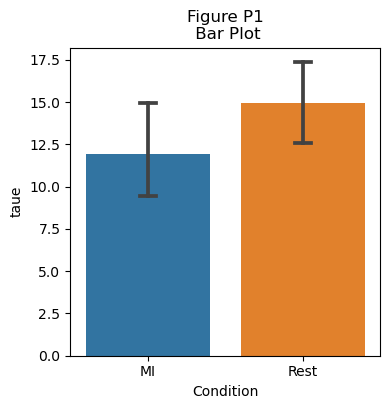

In [34]:
f, ax = plt.subplots(figsize=(4, 4))

sns.barplot(x = "Condition", y = "taue", data = df1, capsize= .1)
plt.title("Figure P1\n Bar Plot")

Text(0.5, 1.0, 'Figure P2\n Basic Rainclouds')

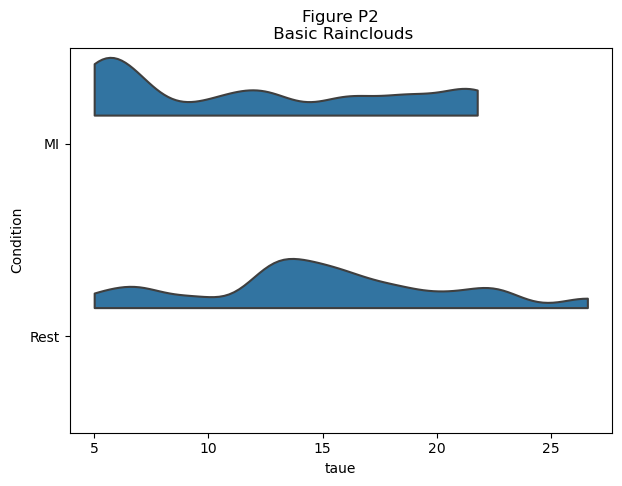

In [35]:
# plotting the clouds
f, ax = plt.subplots(figsize=(7, 5))
dy="Condition"; dx="taue"; ort="h"; pal = sns.color_palette(n_colors=1)

ax=pt.half_violinplot( x = dx, y = dy, data = df1, palette = pal, bw = .2, cut = 0.,
                      scale = "area", width = .6, inner = None, orient = ort)

plt.title("Figure P2\n Basic Rainclouds")

Text(0.5, 1.0, 'Figure P3\n Raincloud Without Jitter')

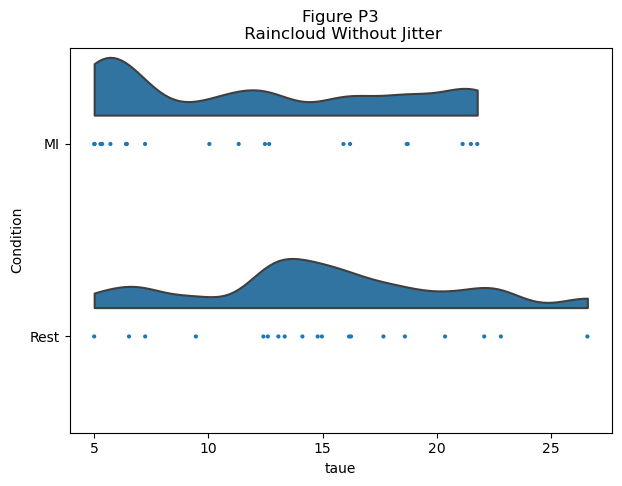

In [36]:
f, ax = plt.subplots(figsize=(7, 5))
ax=pt.half_violinplot( x = dx, y = dy, data = df1, palette = pal, bw = .2, cut = 0.,
                      scale = "area", width = .6, inner = None, orient = ort)
ax=sns.stripplot( x = dx, y = dy, data = df1, palette = pal, edgecolor = "white",
                 size = 3, jitter = 0, zorder = 0, orient = ort)

plt.title("Figure P3\n Raincloud Without Jitter")

Text(0.5, 1.0, 'Figure P4\n Raincloud with Jittered Data')

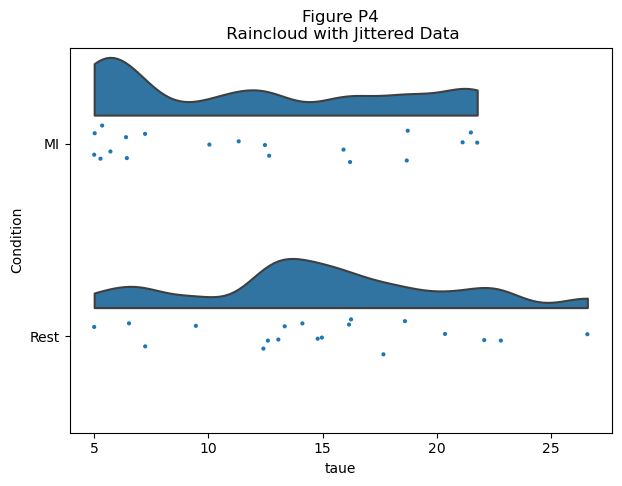

In [37]:
# adding jitter to the rain
f, ax = plt.subplots(figsize=(7, 5))
ax=pt.half_violinplot( x = dx, y = dy, data = df1, palette = pal, bw = .2, cut = 0.,
                      scale = "area", width = .6, inner = None, orient = ort)
ax=sns.stripplot( x = dx, y = dy, data = df1, palette = pal, edgecolor = "white",
                 size = 3, jitter = 1, zorder = 0, orient = ort)

plt.title("Figure P4\n Raincloud with Jittered Data")

Text(0.5, 1.0, 'Figure P5\n Raincloud with Boxplot')

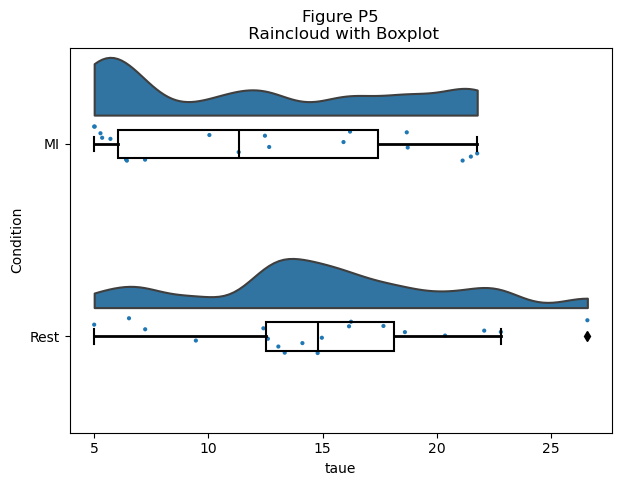

In [38]:
#adding the boxplot with quartiles
f, ax = plt.subplots(figsize=(7, 5))
ax=pt.half_violinplot( x = dx, y = dy, data = df1, palette = pal, bw = .2, cut = 0.,
                      scale = "area", width = .6, inner = None, orient = ort)
ax=sns.stripplot( x = dx, y = dy, data = df1, palette = pal, edgecolor = "white",
                 size = 3, jitter = 1, zorder = 0, orient = ort)
ax=sns.boxplot( x = dx, y = dy, data = df1, color = "black", width = .15, zorder = 10,\
            showcaps = True, boxprops = {'facecolor':'none', "zorder":10},\
            showfliers=True, whiskerprops = {'linewidth':2, "zorder":10},\
               saturation = 1, orient = ort)

plt.title("Figure P5\n Raincloud with Boxplot")

Text(0.5, 1.0, 'Figure P6\n Tweaking the Colour of Raincloud')

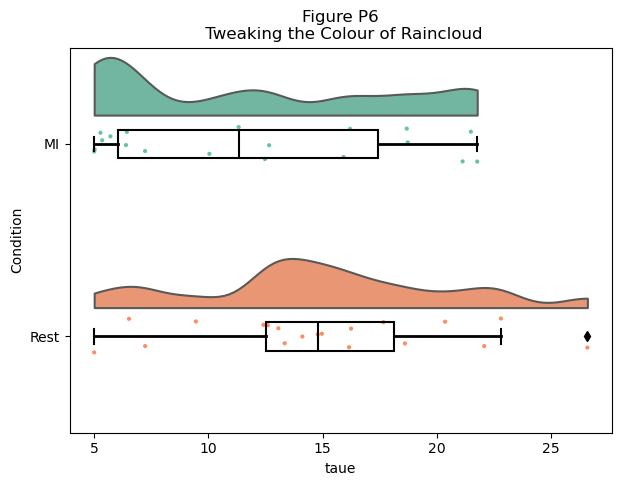

In [39]:
#adding color
pal = "Set2"
f, ax = plt.subplots(figsize=(7, 5))

ax=pt.half_violinplot( x = dx, y = dy, data = df1, palette = pal, bw = .2, cut = 0.,
                      scale = "area", width = .6, inner = None, orient = ort)

ax=sns.stripplot( x = dx, y = dy, data = df1, palette = pal, edgecolor = "white",
                 size = 3, jitter = 1, zorder = 0, orient = ort)
ax=sns.boxplot( x = dx, y = dy, data = df1, color = "black", width = .15, zorder = 10,\
            showcaps = True, boxprops = {'facecolor':'none', "zorder":10},\
            showfliers=True, whiskerprops = {'linewidth':2, "zorder":10},\
               saturation = 1, orient = ort)

plt.title("Figure P6\n Tweaking the Colour of Raincloud")

Text(0.5, 1.0, 'Figure P7\n Using the pt.Raincloud function')

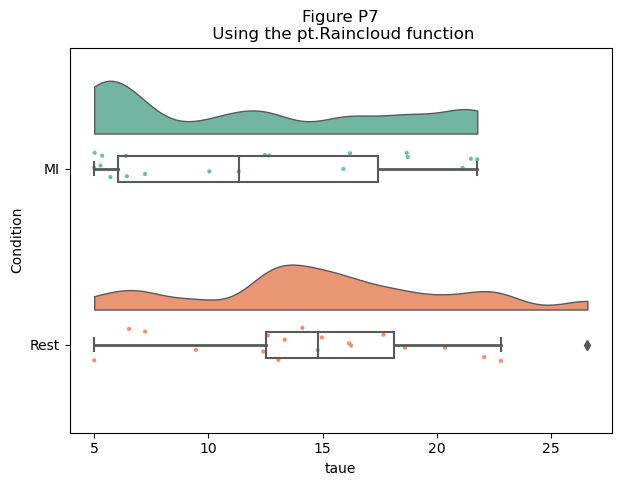

In [40]:
#same thing with a single command: now x **must** be the categorical value
# x = "Condition", y = "taue", data = df1,
dx = "Condition"; dy = "taue"; ort = "h"; pal = "Set2"; sigma = .2
f, ax = plt.subplots(figsize=(7, 5))

pt.RainCloud(x = dx, y = dy, data = df1, palette = pal, bw = sigma,
                 width_viol = .6, ax = ax, orient = ort)

plt.title("Figure P7\n Using the pt.Raincloud function")

Text(0.5, 1.0, 'Figure P8\n Rainclouds with Shifted Rain')

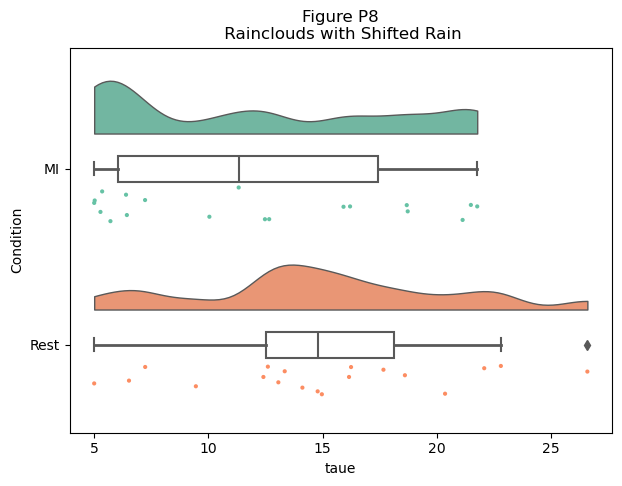

In [41]:
#moving the rain below the boxplot
dx = "Condition"; dy = "taue"; ort = "h"; pal = "Set2"; sigma = .2
f, ax = plt.subplots(figsize=(7, 5))

ax=pt.RainCloud(x = dx, y = dy, data = df1, palette = pal, bw = sigma,
                 width_viol = .6, ax = ax, orient = ort, move = .2)

plt.title("Figure P8\n Rainclouds with Shifted Rain")

In [42]:
np.array(list(df1["taue"]))

array([12.66315801, 10.0444083 , 16.20496109,  7.22804149, 12.47714879,
        6.39425041,  5.        , 21.49492218, 18.72939303,  6.43108511,
        5.34880418, 11.3273167 , 21.13362904,  5.71139973, 18.68768692,
       21.77326775, 15.91796722,  5.02241032,  5.27496494, 13.34327274,
       13.06463905, 18.60667959, 14.78601202, 16.24810098, 16.15997172,
        5.        , 26.59669952, 14.11802017,  6.5242304 , 14.97000634,
       12.60526456, 22.07998235,  9.45248508, 20.36487901, 22.80856422,
       17.66689295,  7.23287865, 12.40992517])

Text(0.5, 1.0, 'Figure P9\n Rainclouds with List/Array Inputs')

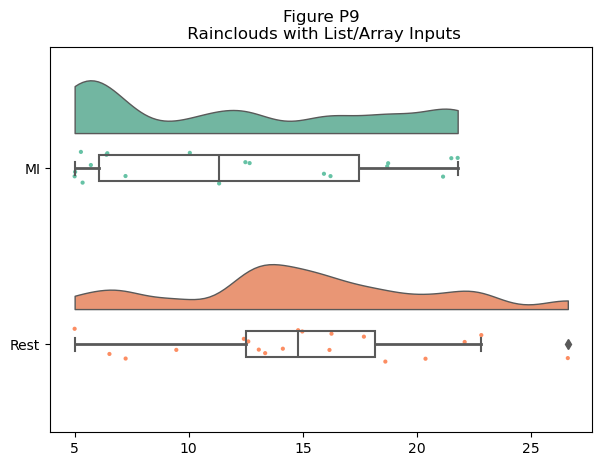

In [43]:
# Usage with a list/np.array input
dx = np.array(list(df1["Condition"])); dy = np.array(list(df1["taue"]))
f, ax = plt.subplots(figsize=(7, 5))

ax=pt.RainCloud(x = dx, y = dy, palette = pal, bw = sigma,
                 width_viol = .6, ax = ax, orient = ort)

plt.title("Figure P9\n Rainclouds with List/Array Inputs")

Text(0.5, 1.0, 'Figure P10\n Flipping your Rainclouds')

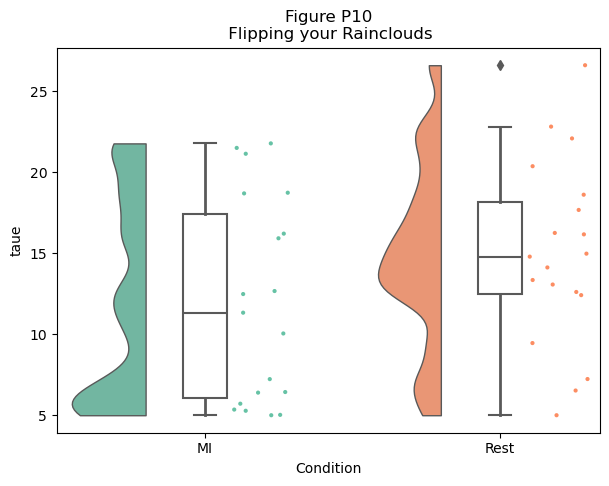

In [44]:
dx="Condition"; dy="taue"; ort="v"; pal = "Set2"; sigma = .2
f, ax = plt.subplots(figsize=(7, 5))

ax=pt.RainCloud(x = dx, y = dy, data = df1, palette = pal, bw = sigma,
                 width_viol = .5, ax = ax, orient = ort, move = .2)

plt.title("Figure P10\n Flipping your Rainclouds")

Text(0.5, 1.0, 'Figure P11\n Customizing Raincloud Smoothness')

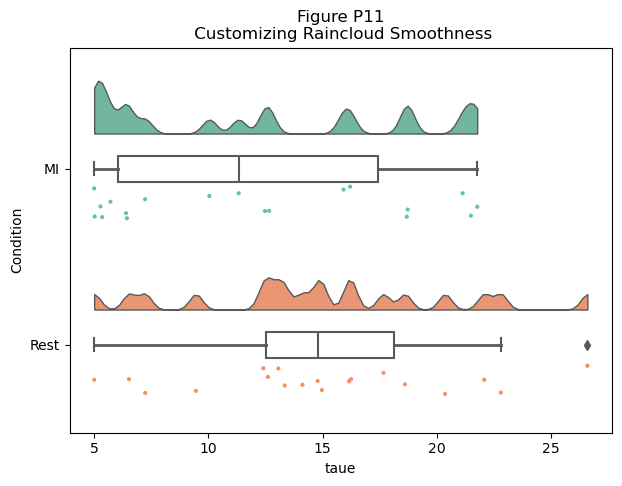

In [45]:
#changing cloud smoothness
dx="Condition"; dy="taue"; ort="h"; pal = "Set2"; sigma = .05
f, ax = plt.subplots(figsize=(7, 5))

ax=pt.RainCloud(x = dx, y = dy, data = df1, palette = pal, bw = sigma,
                 width_viol = .6, ax = ax, orient = ort, move = .2)

plt.title("Figure P11\n Customizing Raincloud Smoothness")

Text(0.5, 1.0, 'Figure P12\n Adding Lineplots to Emphasize Factorial Effects')

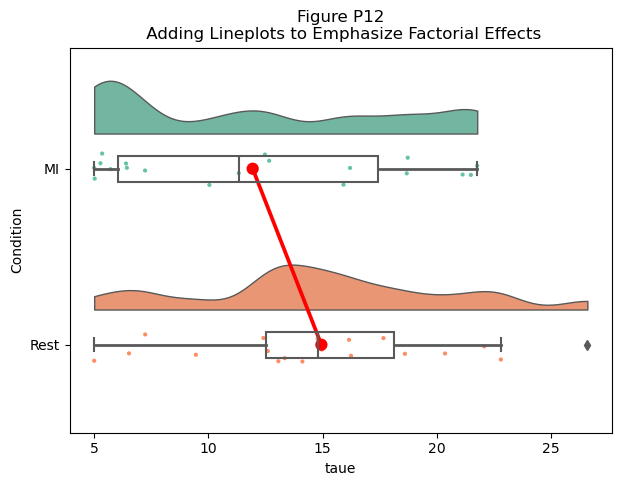

In [46]:
#adding a red line connecting the groups' mean value (useful for longitudinal data)
dx="Condition"; dy="taue"; ort="h"; pal = "Set2"; sigma = .2
f, ax = plt.subplots(figsize=(7, 5))

ax=pt.RainCloud(x = dx, y = dy, data = df1, palette = pal, bw = sigma,
                 width_viol = .6, ax = ax, orient = ort,
               pointplot = True)

plt.title("Figure P12\n Adding Lineplots to Emphasize Factorial Effects")

In [74]:
mi_values[0]

array([12.66315801, 10.0444083 , 16.20496109,  7.22804149, 12.47714879,
        6.39425041,  5.        , 21.49492218, 18.72939303,  6.43108511,
        5.34880418, 11.3273167 , 21.13362904,  5.71139973, 18.68768692,
       21.77326775, 15.91796722,  5.02241032,  5.27496494])

In [47]:
import pandas as pd
import ptitprince as pt
import seaborn as sns
import matplotlib.pyplot as plt


# sessions = range(1, 5)
data_dict = { 'Session':[],'taue': [],'Condition': []}

for i, session in enumerate(sessions):
    data_dict['Session'] += [session] * len(mi_values[i]) + [session] * len(rest_values[i])
    data_dict['taue'] += list(mi_values[i]) + list(rest_values[i])
    data_dict['Condition'] += ['MI'] * len(mi_values[i]) + ['Rest'] * len(rest_values[i])

df5 = pd.DataFrame(data_dict)


In [48]:
df5

,Session,taue,Condition
0,1,12.663158,MI
1,1,10.044408,MI
2,1,16.204961,MI
3,1,7.228041,MI
4,1,12.477149,MI
...,...,...,...
147,4,22.852816,Rest
148,4,21.950787,Rest
149,4,11.390246,Rest
150,4,30.000000,Rest


Text(0.5, 0.98, 'Figure P13\n Using FacetGrid for More Complex Designs')

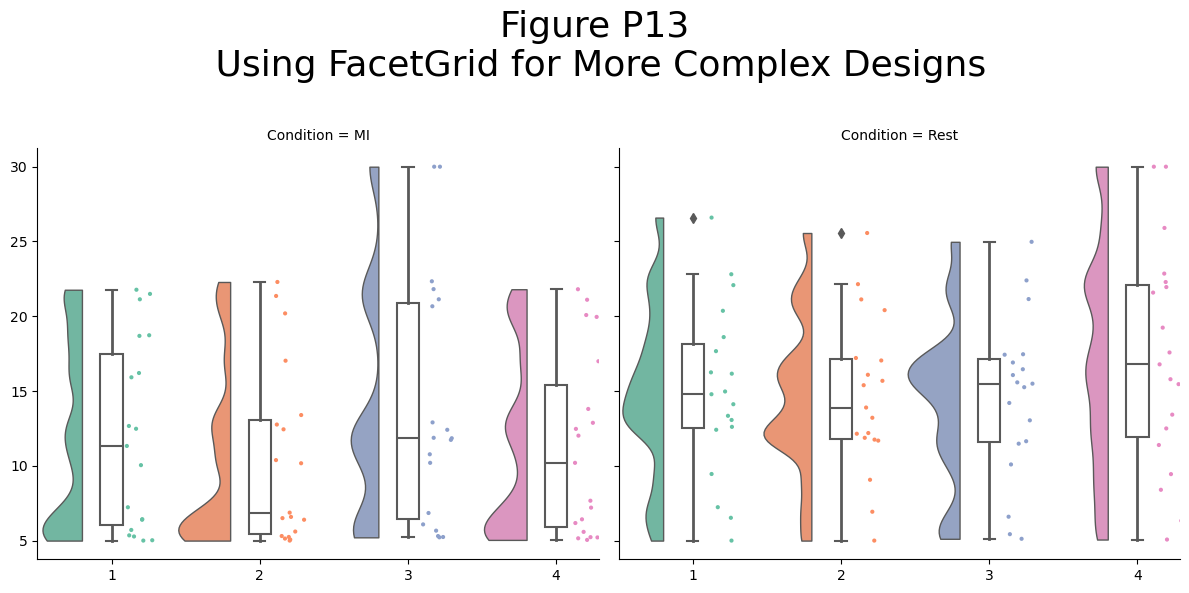

In [49]:
# Rainclouds with FacetGrid
g = sns.FacetGrid(df5, col = "Condition", height = 6)
g = g.map_dataframe(pt.RainCloud, x = "Session", y = "taue", data = df5,
                    orient = "v", move=.2)

g.fig.subplots_adjust(top=0.75)
g.fig.suptitle("Figure P13\n Using FacetGrid for More Complex Designs",  fontsize=26)

## Figure for paper

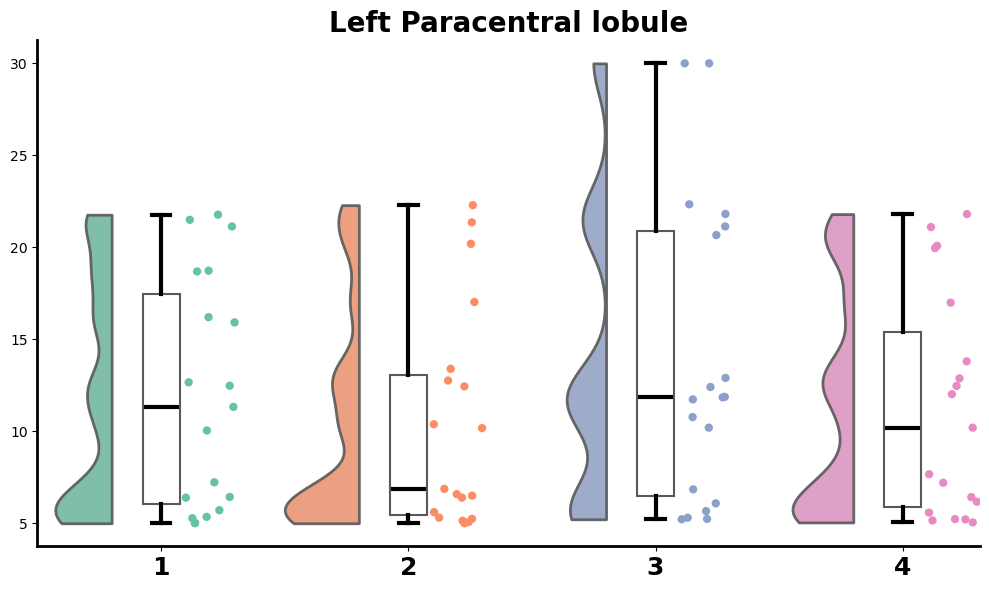

In [70]:
df_mi = df5[df5["Condition"] == "MI"]

plt.figure(figsize=(10, 6))
ax = pt.RainCloud(x="Session", y="taue", data=df_mi,
                  palette="Set2", bw=.2, width_viol=.6, ax=None,
                  orient="v", move=0.2, alpha=0.9, point_size=6, linewidth=2)


for artist in ax.artists:
    artist.set_edgecolor("black") 
    artist.set_linewidth(2)

for line in ax.lines:
    line.set_color("black")  
    line.set_linewidth(3)

plt.title("Left Paracentral lobule", fontweight='bold', fontsize=20)
plt.grid(False)
plt.xlabel("", fontsize=16)
plt.ylabel("", fontsize=16)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(2)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_linewidth(2)
ax.spines['left'].set_color('black')
ax.set_xticklabels([str(s) for s in sessions], fontsize=18, fontweight="bold")
plt.tight_layout()
plt.show()


Text(0.5, 1.0, 'Figure P14\n Rainclouds with Subgroups')

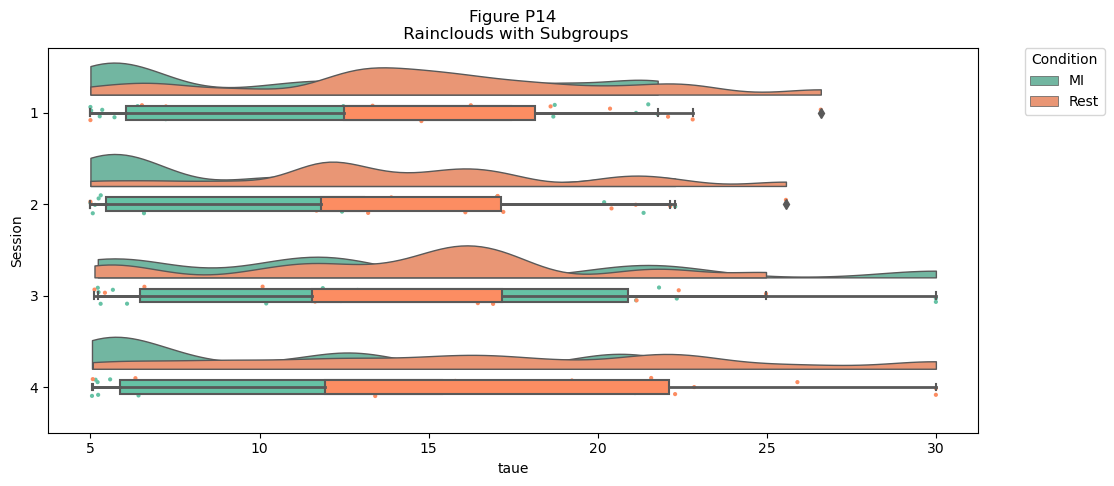

In [125]:
# Hue Input for Subgroups
dx="Session"; dy="taue"; dhue = "Condition"; ort="h"; pal = "Set2"; sigma = .2
f, ax = plt.subplots(figsize=(12, 5))

ax=pt.RainCloud(x = dx, y = dy, hue = dhue, data = df5, palette = pal, bw = sigma,
                 width_viol = .7, ax = ax, orient = ort)

plt.title("Figure P14\n Rainclouds with Subgroups")

Text(0.5, 1.0, 'Figure P15\n Adjusting Raincloud Alpha Level')

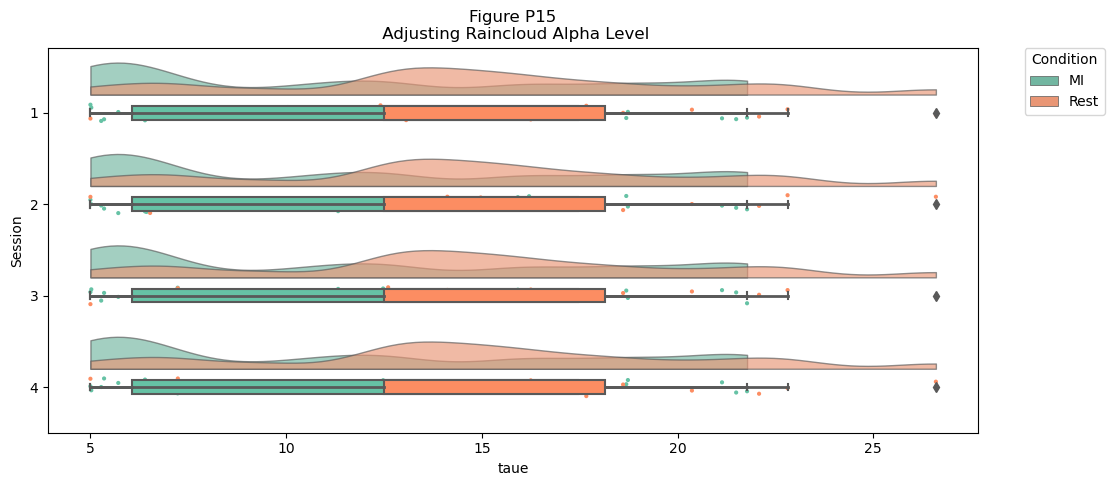

In [88]:
# Setting alpha level
f, ax = plt.subplots(figsize=(12, 5))

ax=pt.RainCloud(x = dx, y = dy, hue = dhue, data = df2, palette = pal, bw = sigma,
                 width_viol = .7, ax = ax, orient = ort , alpha = .65)

plt.title("Figure P15\n Adjusting Raincloud Alpha Level")

Text(0.5, 1.0, 'Figure P16\n The Boxplot Dodge Flag')

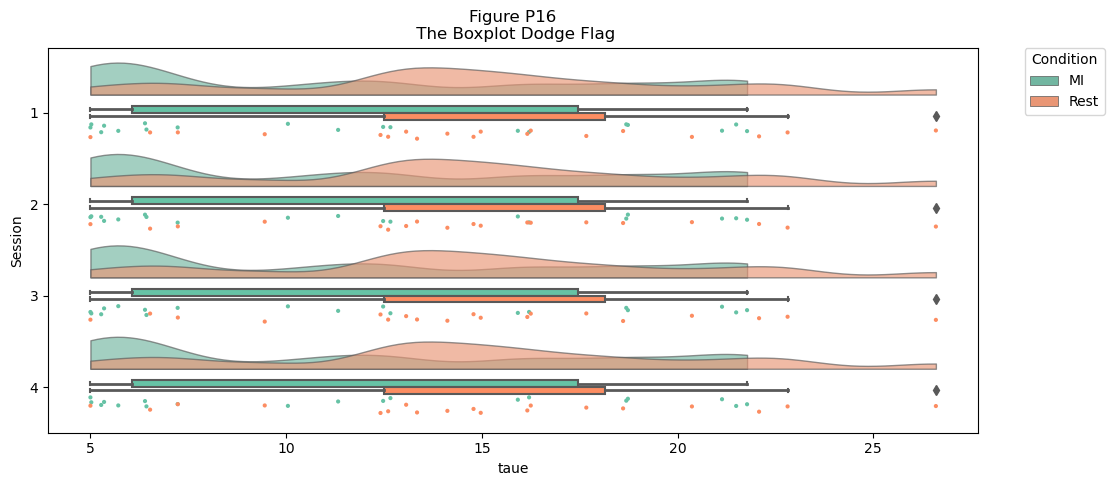

In [96]:
#The Doge Flag
f, ax = plt.subplots(figsize=(12, 5))

ax=pt.RainCloud(x = dx, y = dy, hue = dhue, data = df2, palette = pal, bw = sigma,
                 width_viol = .7, ax = ax, orient = ort , alpha = .65, dodge = True, move=.2)

plt.title("Figure P16\n The Boxplot Dodge Flag")

Text(0.5, 1.0, 'Figure P17\n Dodged Boxplots with Lineplots')

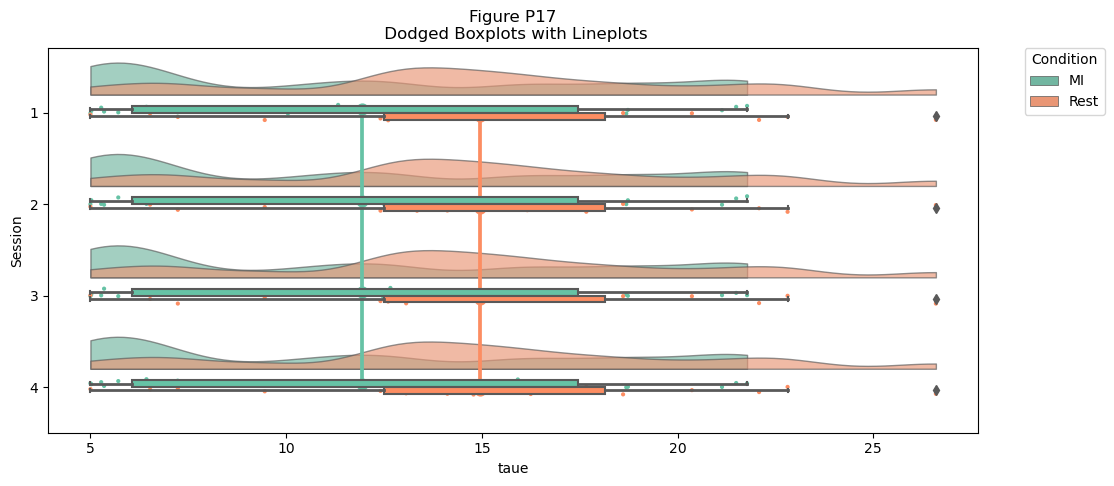

In [90]:
#same, with dodging and line
f, ax = plt.subplots(figsize=(12, 5))
ax=pt.RainCloud(x = dx, y = dy, hue = dhue, data = df2, palette = pal, bw = sigma, width_viol = .7,
                ax = ax, orient = ort , alpha = .65, dodge = True, pointplot = True)

plt.title("Figure P17\n Dodged Boxplots with Lineplots")

Text(0.5, 1.0, 'Figure P18\n Shifting the Rain with the Move Parameter')

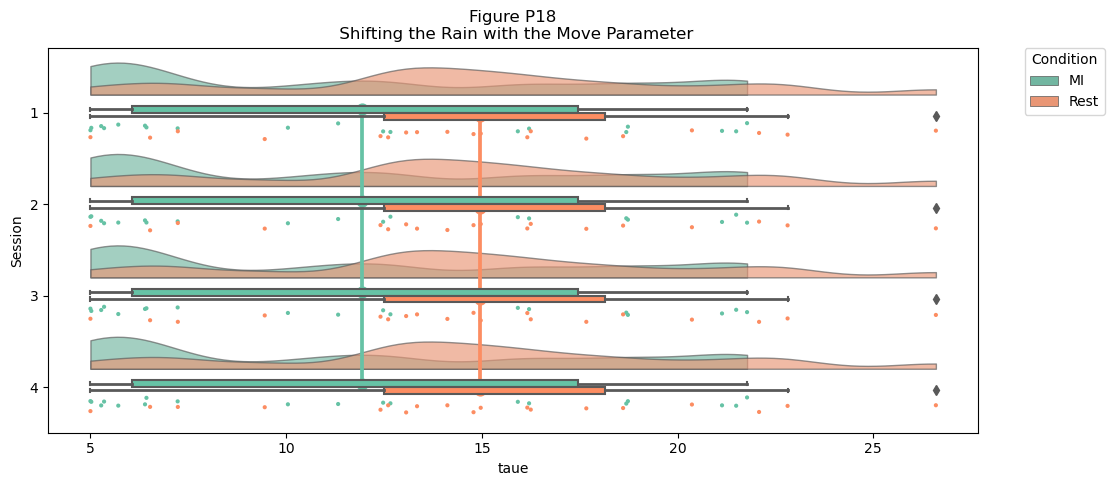

In [91]:
f, ax = plt.subplots(figsize=(12, 5))

ax=pt.RainCloud(x = dx, y = dy, hue = dhue, data = df2, palette = pal, bw = sigma, width_viol = .7,
                ax = ax, orient = ort , alpha = .65, dodge = True, pointplot = True, move = .2)

plt.title("Figure P18\n Shifting the Rain with the Move Parameter")

In [ ]:
import ptitprince as pt

pt.RainCloud(x = dx, y = dy, data = df, palette = pal, bw = sigma,
                 width_viol = .6, ax = ax, orient = ort)

In [24]:
import pandas as pd
import ptitprince as pt
import seaborn as sns
import matplotlib.pyplot as plt

# Prepare long-form DataFrame
sessions = range(1, 5)
data_dict = {'Session': [], 'Condition': [], 'Value': []}

for i, session in enumerate(sessions):
    data_dict['Session'] += [session] * len(mi_values[i]) + [session] * len(rest_values[i])
    data_dict['Condition'] += ['MI'] * len(mi_values[i]) + ['Rest'] * len(rest_values[i])
    data_dict['Value'] += list(mi_values[i]) + list(rest_values[i])

df = pd.DataFrame(data_dict)


In [28]:
df.head(20)

,Session,Condition,Value
0,1,MI,12.663158
1,1,MI,10.044408
2,1,MI,16.204961
3,1,MI,7.228041
4,1,MI,12.477149
5,1,MI,6.394250
6,1,MI,5.000000
7,1,MI,21.494922
8,1,MI,18.729393
9,1,MI,6.431085


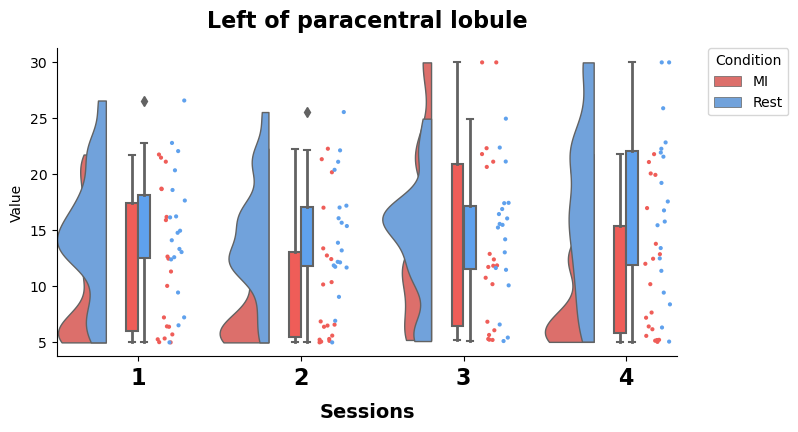

In [40]:
import pandas as pd
import ptitprince as pt
import seaborn as sns
import matplotlib.pyplot as plt


sessions = range(1, 5)
data_dict = {'Session': [], 'Condition': [], 'Value': []}

for i, session in enumerate(sessions):
    data_dict['Session'] += [session] * len(mi_values[i]) + [session] * len(rest_values[i])
    data_dict['Condition'] += ['MI'] * len(mi_values[i]) + ['Rest'] * len(rest_values[i])
    data_dict['Value'] += list(mi_values[i]) + list(rest_values[i])

df = pd.DataFrame(data_dict)

pal = {'MI': '#EF5D58', 'Rest': '#5FA1ED'}

plt.figure(figsize=(8, 4))
ax = plt.gca()

pt.RainCloud(x='Session', y='Value', hue='Condition', data=df, palette=pal, bw=.3, width_viol=.6, ax=ax, orient='v',
             move=.2, dodge=True)



ax.set_title(f"Left of {all_regions[32][:-2]} lobule", fontsize=16, fontweight="bold", pad=15)
ax.set_xlabel("Sessions", fontsize=14, fontweight="bold", labelpad=10)
ax.set_xticks(range(4))
ax.grid(False)
ax.set_xticklabels([str(s) for s in sessions], fontsize=16, fontweight="bold")

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# plt.tight_layout()
plt.show()

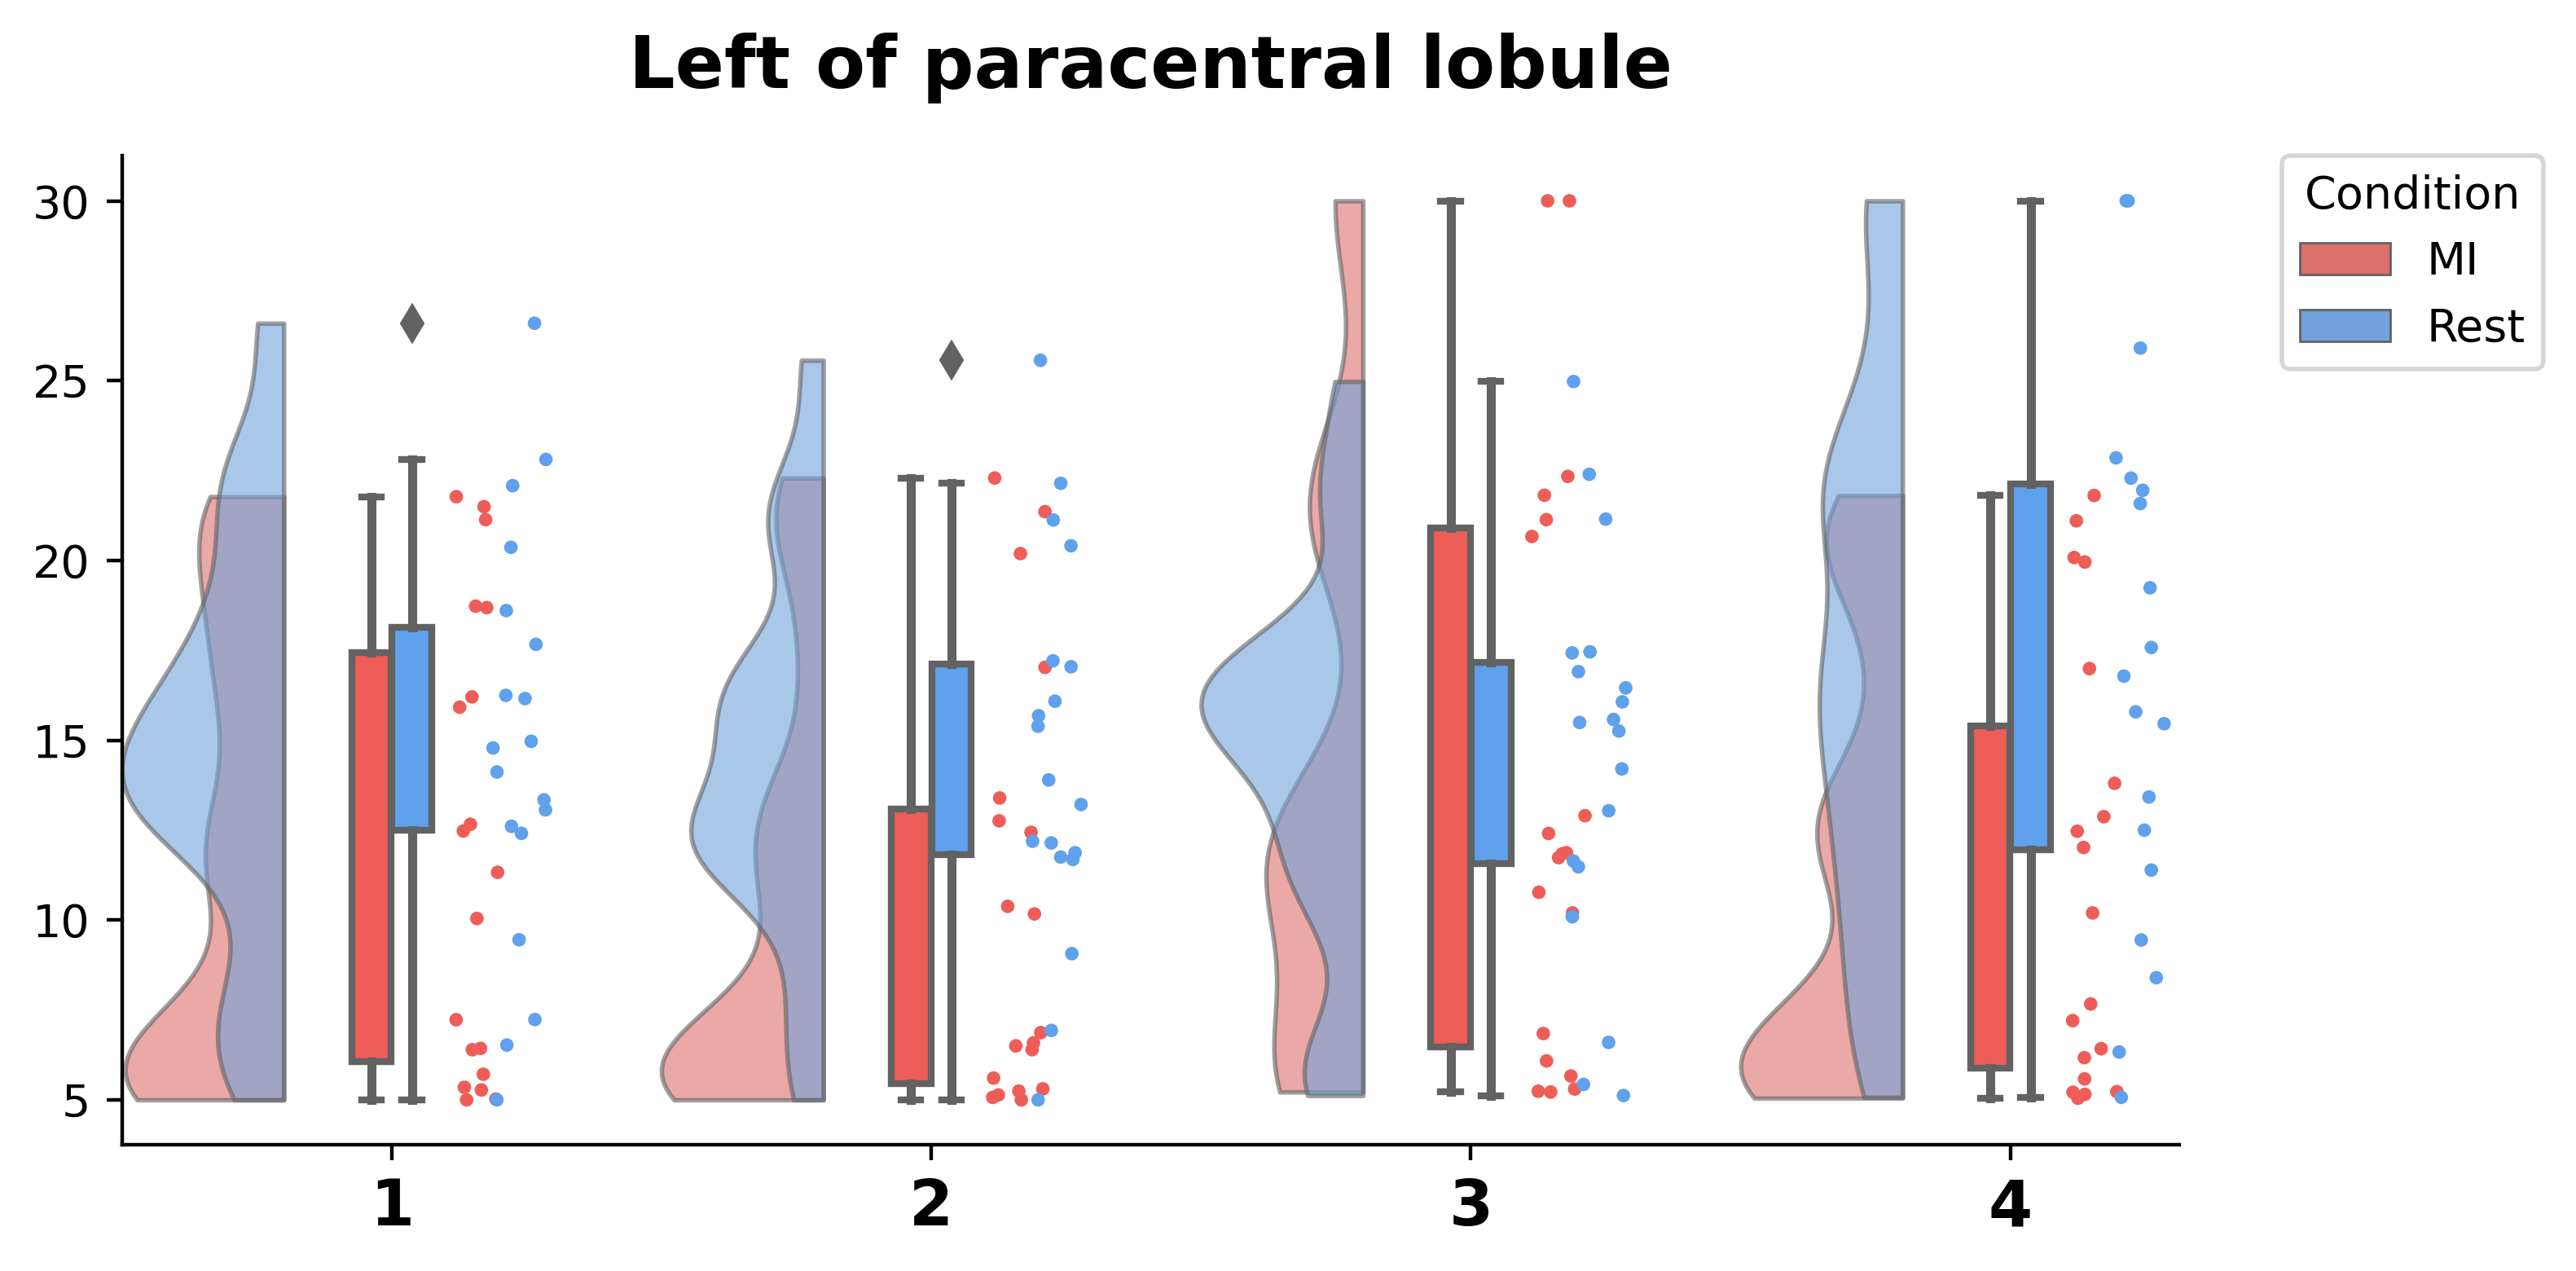

In [65]:
import pandas as pd
import ptitprince as pt
import seaborn as sns
import matplotlib.pyplot as plt

sessions = range(1, 5)
data_dict = {'Session': [], 'Condition': [], 'Value': []}

for i, session in enumerate(sessions):
    data_dict['Session'] += [session] * len(mi_values[i]) + [session] * len(rest_values[i])
    data_dict['Condition'] += ['MI'] * len(mi_values[i]) + ['Rest'] * len(rest_values[i])
    data_dict['Value'] += list(mi_values[i]) + list(rest_values[i])

df = pd.DataFrame(data_dict)

pal = {'MI': '#EF5D58', 'Rest': '#5FA1ED'}


plt.figure(figsize=(8, 4), dpi=400)
ax = plt.gca()

pt.RainCloud(x='Session', y='Value', hue='Condition', data=df, palette=pal, bw=.3,
             width_viol=.6, ax=ax, orient='v', move=.2, dodge=True, alpha=0.6)

ax.set_title(f"Left of {all_regions[32][:-2]} lobule", fontsize=16, fontweight="bold", pad=15)
# ax.set_xlabel("Sessions", fontsize=14, fontweight="bold", labelpad=10)
ax.set_xlabel('')  
ax.set_ylabel('')

ax.set_xticks(range(4))
ax.set_xticklabels([str(s) for s in sessions], fontsize=14, fontweight="bold")
ax.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# plt.legend_.remove() 
plt.tight_layout()
plt.show()


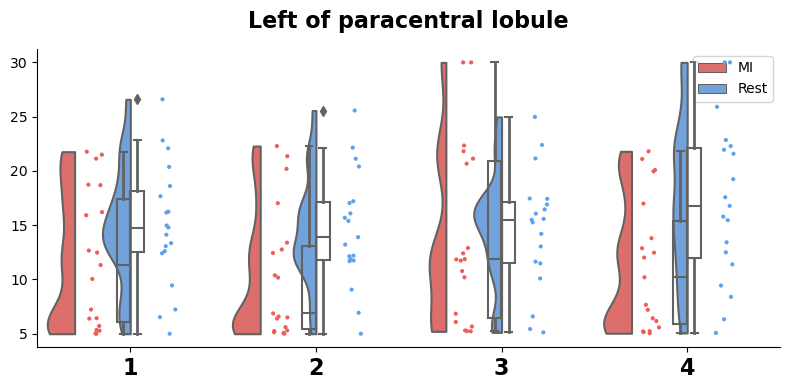

In [56]:
# Start figure
plt.figure(figsize=(8, 4))
ax = plt.gca()

# 1. Violin (cloud) first — goes to the back
pt.half_violinplot(
    x='Session', y='Value', hue='Condition', data=df, palette=pal,
    bw=.3, cut=0., scale='area', width=.6, inner=None, orient='v',
    dodge=True, ax=ax
)

# 2. Boxplot — middle layer
sns.boxplot(
    x='Session', y='Value', hue='Condition', data=df,
    showcaps=True,
    boxprops={'facecolor': 'none', 'zorder': 10},
    whiskerprops={'linewidth': 2, 'zorder': 10},
    # medianprops={'color': 'black', 'linewidth': 3},  # Q2 line emphasized
    showfliers=True, linewidth=1.5, width=0.15, dodge=True,
    palette=pal, orient='v', ax=ax
)

# 3. Scatter — top layer
sns.stripplot(
    x='Session', y='Value', hue='Condition', data=df, palette=pal,
    edgecolor="white", size=3, jitter=1, zorder=20, dodge=True,
    orient='v', ax=ax
)

# Remove duplicate legends from multiple plots
handles, labels = ax.get_legend_handles_labels()
if ax.legend_:
    ax.legend_.remove()
ax.legend(handles[:2], labels[:2], loc='upper right')  # Keep only one legend set

# Final touches
ax.set_title(f"Left of {all_regions[32][:-2]} lobule", fontsize=16, fontweight="bold", pad=15)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xticks(range(4))
ax.set_xticklabels([str(s) for s in range(1, 5)], fontsize=16, fontweight="bold")
ax.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()
